https://susanqq.github.io/UTKFace/

In [1]:
from fastai.vision.all import *
np.random.seed(641)

In [2]:
# !gdown https://drive.google.com/uc?id=0BxYys69jI14kRjNmM0gyVWM2bHM
!gdown https://drive.google.com/uc?id=0BxYys69jI14kYVM3aVhKS1VhRUk  # Cropped faces
!gdown https://drive.google.com/uc?id=0BxYys69jI14kSi1abVV0YWFLWTg  #part1.txt
!gdown https://drive.google.com/uc?id=0BxYys69jI14kQlZhMVZuYnBWdUk  #part2.txt
!gdown https://drive.google.com/uc?id=0BxYys69jI14kLWoyYXVJTGNkWkE  #part3.txt

Downloading...
From: https://drive.google.com/uc?id=0BxYys69jI14kYVM3aVhKS1VhRUk
To: /content/UTKFace.tar.gz
100% 107M/107M [00:02<00:00, 48.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=0BxYys69jI14kSi1abVV0YWFLWTg
To: /content/landmark_list_part1.txt
100% 4.96M/4.96M [00:00<00:00, 140MB/s]
Downloading...
From: https://drive.google.com/uc?id=0BxYys69jI14kQlZhMVZuYnBWdUk
To: /content/landmark_list_part2.txt
100% 5.44M/5.44M [00:00<00:00, 263MB/s]
Downloading...
From: https://drive.google.com/uc?id=0BxYys69jI14kLWoyYXVJTGNkWkE
To: /content/landmark_list_part3.txt
100% 1.63M/1.63M [00:00<00:00, 93.4MB/s]


In [3]:
# !tar -xvf /content/part1.tar.gz >&NULL
# !tar -xvf /content/crop_part1.tar.gz >&NULL
!tar -xvf /content/UTKFace.tar.gz >&NULL
!rm NULL

In [4]:
import cv2
from glob import glob
import os

image_dir='UTKFace/'
image_list=glob(image_dir+'*')
print(len(image_list),image_list[:4])
del image_list

23708 ['UTKFace/30_1_1_20170116021054972.jpg.chip.jpg', 'UTKFace/35_0_1_20170116002219767.jpg.chip.jpg', 'UTKFace/75_0_1_20170116204836635.jpg.chip.jpg', 'UTKFace/25_1_4_20170103230304689.jpg.chip.jpg']


In [5]:
train_data=np.loadtxt('landmark_list_part1.txt',dtype=str)
train_data=np.r_[train_data,np.loadtxt('landmark_list_part2.txt',dtype=str)]
train_data=np.r_[train_data, np.array(list(filter(lambda x:(len(x)==137), map(lambda x: x.split(' ')[:-1],open('landmark_list_part3.txt','r').read().split('\n'))))) ]
train_data[20646][0]=train_data[20646][0][:-2]+'jpg'  # fixing a example
train_data=train_data.astype('<U46')
train_data.shape

(23707, 137)

In [6]:
train_data[20646,0]

'44_1_4_20170116235150272.jpg'

In [7]:
train_data[:,0]=np.array(list(map(lambda x: str(image_dir+x+".chip.jpg"),train_data[:,0])))
# train_data[:,0]

In [8]:
# failed_paths=verify_images(list(map(lambda x: image_dir+x+".chip.jpg",train_data[:,0])) )
failed_paths=['UTKFace/61_3_20170109150557335.jpg.chip.jpg','UTKFace/53__0_20170116184028385.jpg.chip.jpg']
for failed_path in failed_paths:
  idx=np.where(train_data[:,0]==failed_path)
  train_data=np.delete(train_data,idx[0][0],axis=0)

In [9]:
len(train_data)

23705

In [10]:
train_data.shape

(23705, 137)

In [11]:
load_points=lambda points: points.reshape(-1,2).astype(np.float32)
load_points(train_data[1,1:]).shape

(68, 2)

In [12]:
PILImage.create(train_data[54,0]).shape

(200, 200)

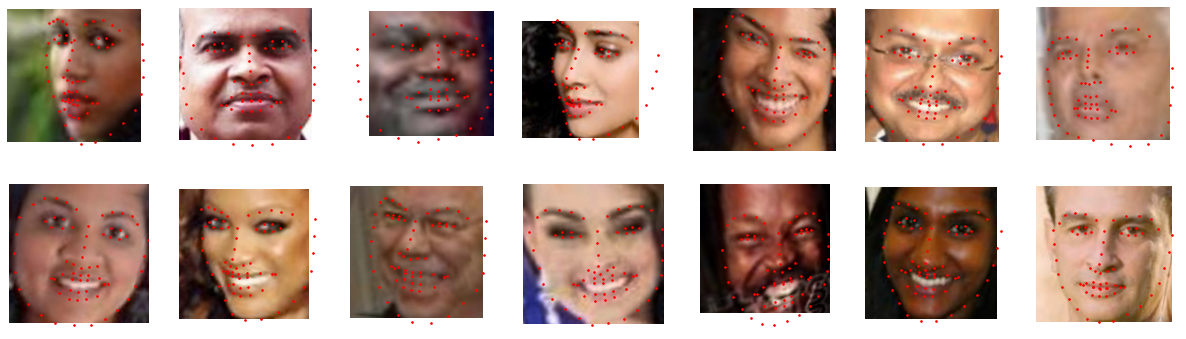

In [235]:
dblock=DataBlock(
                blocks=[ImageBlock,PointBlock],
                item_tfms=Resize(200,method=ResizeMethod.Squish),
                # batch_tfms=[Normalize.from_stats(*imagenet_stats)],
                batch_tfms=[*aug_transforms(do_flip=False),Normalize.from_stats(*imagenet_stats)],
                get_x=lambda x: x[0],
                get_y=lambda y: load_points(y[1:]),
                splitter=RandomSplitter(0.2,675)
)
# ds=dblock.datasets(all_list)
# ds[0]
dls=dblock.dataloaders(train_data)
dls.train.show_batch(max_n=14,ncols=7)

In [236]:
# dls.one_batch()[1]

In [237]:
# learner=vision_learner(dls,models.resnet18, y_range=(-1,1))
learner=vision_learner(dls,models.resnet50, y_range=(-1,1))

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:136: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  f"Using {sequence_to_str(tuple(keyword_only_kwargs.keys()), separate_last='and ')} as positional "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [238]:
print('Loss func ', learner.loss_func)

Loss func  FlattenedLoss of MSELoss()


In [239]:
# learner.lr_find()

In [240]:
# learner.load('stage_1')

In [241]:
learner.fit_one_cycle(16,lr_max=slice(0.006),cbs=[SaveModelCallback(fname='best_model')])

epoch,train_loss,valid_loss,time
0,0.166085,0.039369,02:33
1,0.030904,0.014108,02:32
2,0.024666,0.018758,02:33
3,0.014115,0.006398,02:32
4,0.008423,0.008199,02:33
5,0.006321,0.005041,02:32
6,0.005022,0.003814,02:32
7,0.004322,0.002307,02:32
8,0.003884,0.001795,02:32
9,0.003661,0.001834,02:32


Better model found at epoch 0 with valid_loss value: 0.039368823170661926.
Better model found at epoch 1 with valid_loss value: 0.014107550494372845.
Better model found at epoch 3 with valid_loss value: 0.0063978456892073154.
Better model found at epoch 5 with valid_loss value: 0.005041276570409536.
Better model found at epoch 6 with valid_loss value: 0.0038140041287988424.
Better model found at epoch 7 with valid_loss value: 0.0023070245515555143.
Better model found at epoch 8 with valid_loss value: 0.0017954412614926696.
Better model found at epoch 10 with valid_loss value: 0.0015336173819378018.
Better model found at epoch 14 with valid_loss value: 0.0013275130186229944.


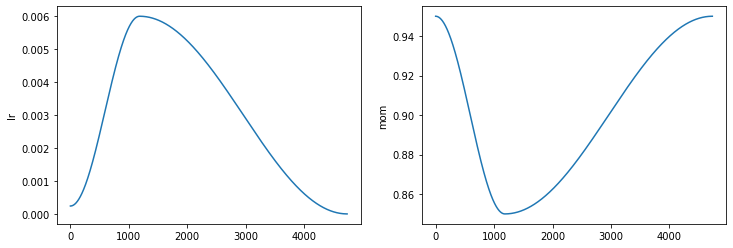

In [242]:
learner.recorder.plot_sched()

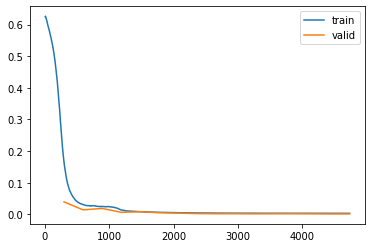

In [243]:
learner.recorder.plot_loss()

In [244]:
# learner.load('best_model')
learner.save('stage_1')

Path('models/stage_1.pth')

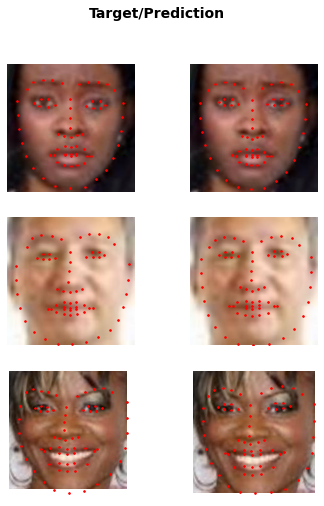

In [245]:
# learner.show_results()
learner.show_results(ds_idx=1, nrows=3, figsize=(6,8))

In [246]:
# learner.load('stage_1')
# learner.unfreeze()

SuggestedLRs(valley=3.630780702224001e-05)

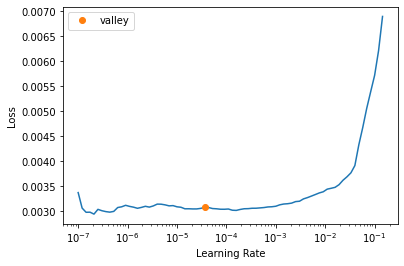

In [255]:
learner.unfreeze()
learner.lr_find()

In [256]:
learner.fit_one_cycle(8,lr_max=slice(1e-6,5e-5),cbs=SaveModelCallback(fname='best_model'))

epoch,train_loss,valid_loss,time
0,0.003131,0.001313,03:21
1,0.003101,0.001294,03:21
2,0.003064,0.001260,03:21
3,0.003046,0.001226,03:21
4,0.003018,0.001208,03:26
5,0.002988,0.001189,03:22
6,0.003034,0.001192,03:21
7,0.002965,0.001192,03:21


Better model found at epoch 0 with valid_loss value: 0.0013126339763402939.
Better model found at epoch 1 with valid_loss value: 0.001294376328587532.
Better model found at epoch 2 with valid_loss value: 0.0012597930617630482.
Better model found at epoch 3 with valid_loss value: 0.0012258448405191302.
Better model found at epoch 4 with valid_loss value: 0.0012077924329787493.
Better model found at epoch 5 with valid_loss value: 0.0011889844899997115.


In [257]:
learner.load('best_model')
learner.save('stage_2') 

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:59: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


Path('models/stage_2.pth')

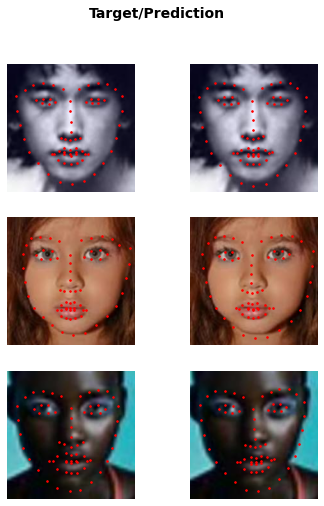

In [258]:
learner.show_results(ds_idx=1, nrows=3, figsize=(6,8))

In [260]:
def get_preds(test_img):
  test_img,test_preds,_,_=learner.predict(test_img,with_input=True)
  test_img=test_img.numpy()
  for p in test_preds:  test_img[:,p[1].int(),p[0].int()]=[255,0,0]  
  # test_img.shape
  PILImage.create(TensorImage(test_img)).show()

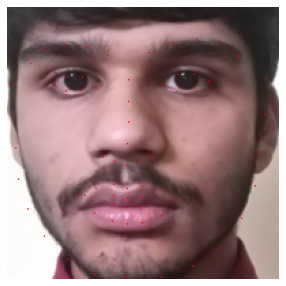

In [261]:
get_preds("anuj_face.jpg")

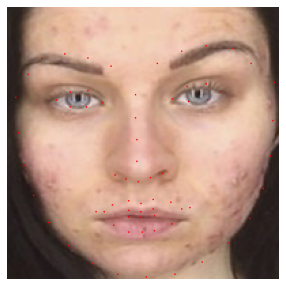

In [268]:
get_preds("acne (2).jpg")

**this works well only on cropped alligned faces**